# Load modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 205 GB / percent used: 18.6 %


# Load model data

In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'

# Check the differences between ERA-Interim and model for Near-Surface Air Temperature

## Load first member

In [3]:
realization = 'r1i1p1f1'
var = 'tas'
table = 'Amon'

# Load historical
tas = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]-273.15

# ERA-Interim
tas_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/t2.*.asmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).t2.sel(time=period).load()-273.15

## Regrid

In [4]:
regridder = xe.Regridder(tas_era, tas, 'bilinear', periodic=True, reuse_weights=True)
tas_era_regrid = regridder(tas_era)

Reuse existing file: bilinear_241x480_143x144_peri.nc


## Select zone

In [5]:
tas = tas.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()
tas_era_regrid = tas_era_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()

## Compute clim

In [6]:
tas_clim = tas.mean('time')
tas_era_regrid_clim = tas_era_regrid.mean('time')

In [7]:
tas_bias = tas_clim-tas_era_regrid_clim

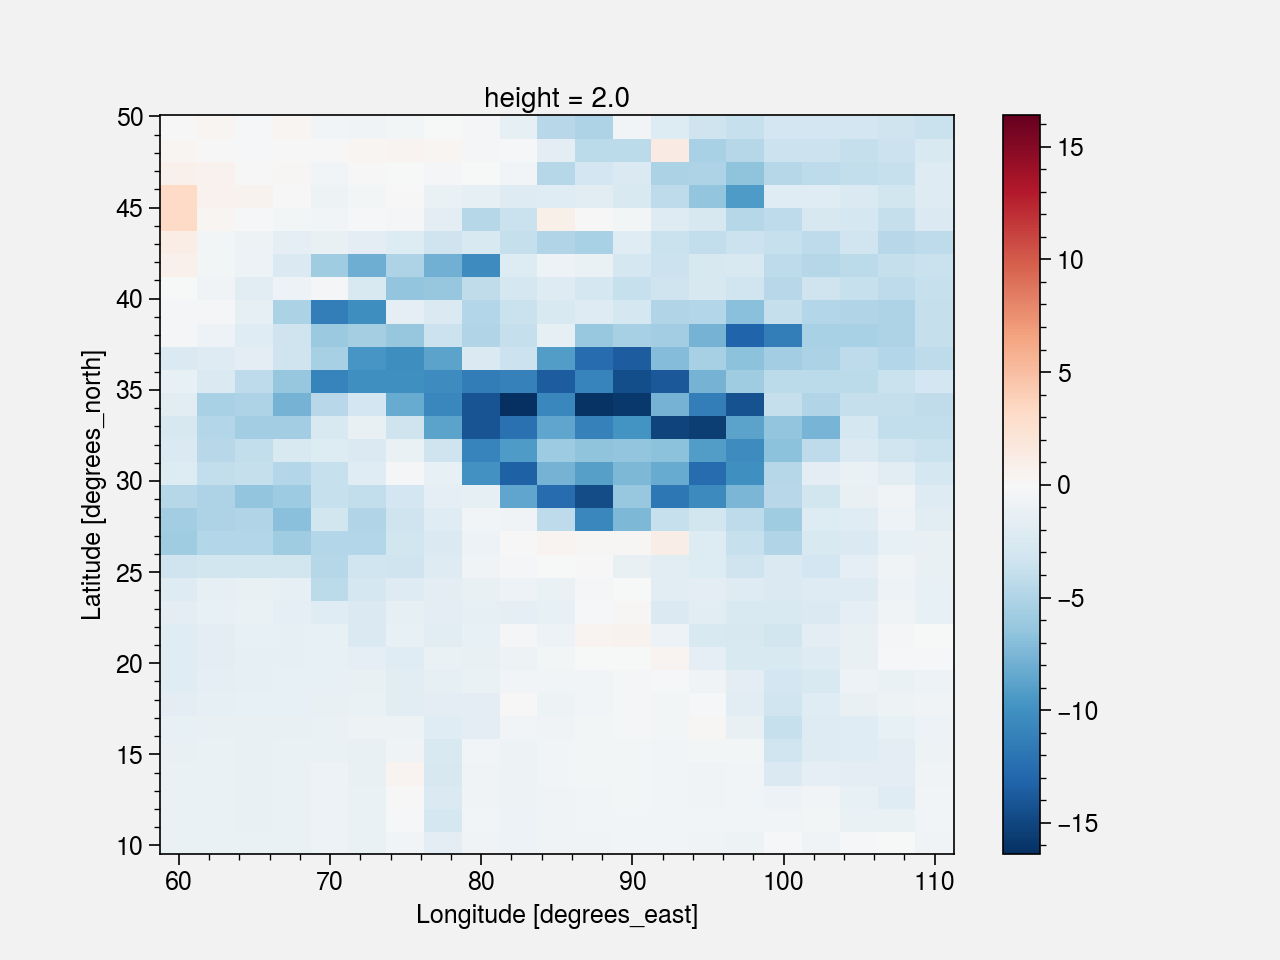

In [8]:
tas_bias.plot()

In [9]:
tas_bias.max()

<xarray.DataArray ()>
array(3.31948477)
Coordinates:
    height   float64 2.0

In [10]:
tas_bias.min()

<xarray.DataArray ()>
array(-16.39639211)
Coordinates:
    height   float64 2.0

In [14]:
tas.lon.values

array([ 60. ,  62.5,  65. ,  67.5,  70. ,  72.5,  75. ,  77.5,  80. ,
        82.5,  85. ,  87.5,  90. ,  92.5,  95. ,  97.5, 100. , 102.5,
       105. , 107.5, 110. ], dtype=float32)

In [15]:
tas.lat.values

array([10.140845, 11.408451, 12.676056, 13.943662, 15.211267, 16.478872,
       17.746479, 19.014084, 20.28169 , 21.549295, 22.816902, 24.084507,
       25.352112, 26.619719, 27.887323, 29.15493 , 30.422535, 31.690142,
       32.957745, 34.225353, 35.492958, 36.760563, 38.028168, 39.295776,
       40.56338 , 41.830986, 43.09859 , 44.366196, 45.633804, 46.90141 ,
       48.169014, 49.43662 ], dtype=float32)

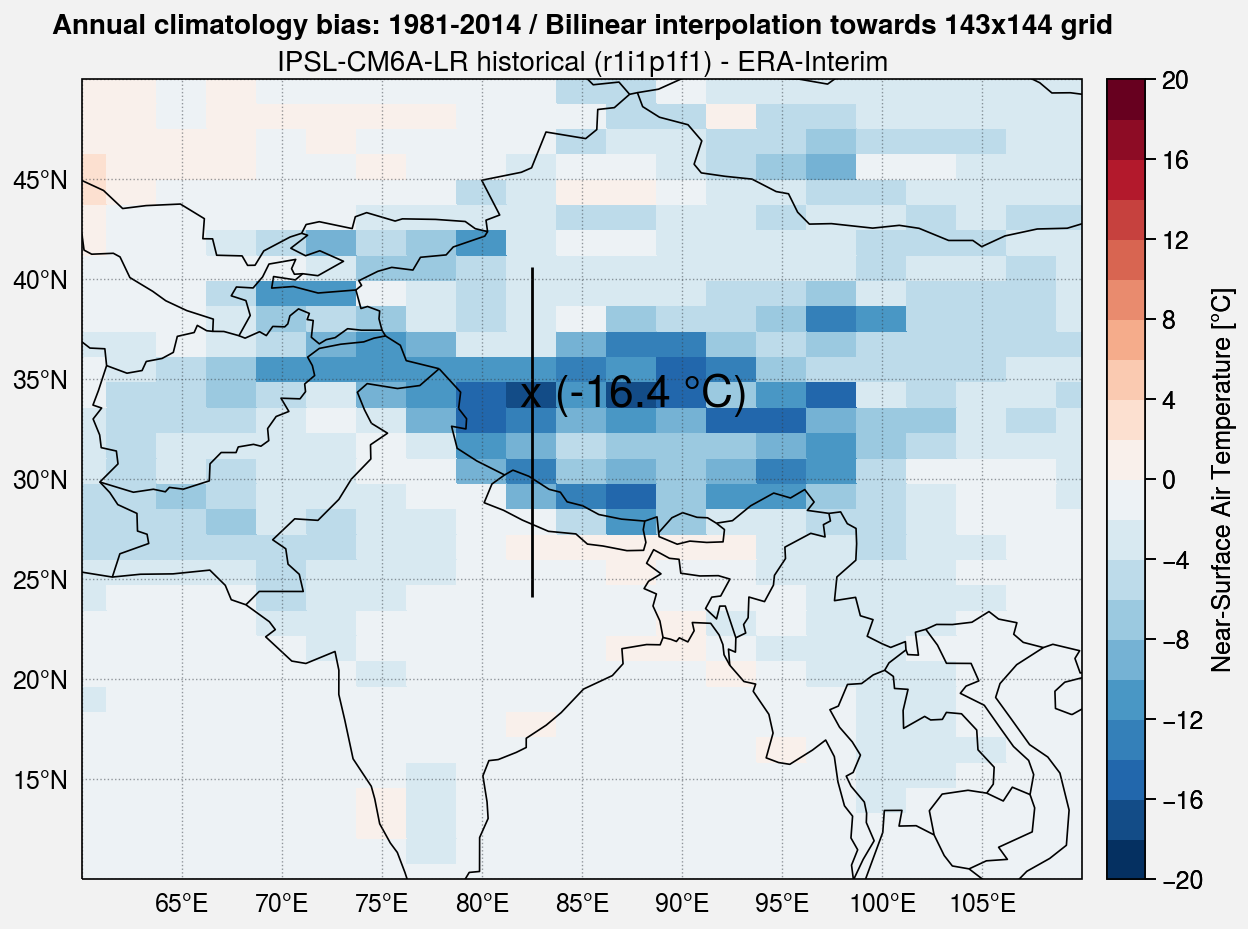

In [12]:
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

dx=2.5
dy=1.2676

f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, axwidth=5)

m = axs[0].pcolormesh(tas_bias, cmap='RdBu_r', levels=plot.arange(-20,20,2))
axs[0].format(title='IPSL-CM6A-LR historical (r1i1p1f1) - ERA-Interim')

f.colorbar(m, label='Near-Surface Air Temperature [°C]')

# Add boxes
# for ax in axs:
#     u.plot_zones_IPSL_CM6A_LR(ax)
    
axs[0].add_patch(mpatches.Rectangle(
    xy=[82.5, 24.084507], width=0, height=40.56338-24.084507,
    transform=ccrs.PlateCarree(), fill=False
))
axs[0].text(82.5-dx/4, 34.225353-dy/2, 'x (-16.4 °C)', fontsize=16, 
#             horizontalalignment='center', verticalalignment='center'
           )

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Annual climatology bias: 1981-2014 / Bilinear interpolation towards 143x144 grid",
    lonlines=5, latlines=5, abc=False, latlim=latlim, lonlim=lonlim
)

# var = 'ta'
# f.save('img/'+var+'/tas_IPSL_CMIP6-ERAI_bias.png')
# f.save('img/'+var+'/tas_IPSL_CMIP6-ERAI_bias.pdf')

In [13]:
tas_bias.sel(lat=34.225353, lon=82.5)

<xarray.DataArray ()>
array(-16.39639211)
Coordinates:
    lat      float32 34.225353
    lon      float32 82.5
    height   float64 2.0

In [58]:
tas_bias.sel(lat=30.422535, lon=82.5)

<xarray.DataArray ()>
array(-13.37309474)
Coordinates:
    lat      float32 30.422535
    lon      float32 82.5
    height   float64 2.0

# Load surface pressure for masking ERA-Interim
http://clipc-services.ceda.ac.uk/dreq/u/8c9504d28596e05586c8e193082ac617.html

In [14]:
realization = 'r1i1p1f1'
var = 'ps'
table = 'Amon'

# Load historical
ps = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]

# ERA-Interim
ps_era = xr.open_mfdataset(
    "/data/mlalande/ERAI/sp/sp_ERAI_*.nc",
    combine='by_coords', parallel=True
).sp.sel(time=period).load()

In [37]:
ps_era_regrid = regridder(ps_era)

ps = ps.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()
ps_era_regrid = ps_era_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()

ps_clim = ps.mean('time')
ps_era_regrid_clim = ps_era_regrid.mean('time')

# Load Air Temperature

In [15]:
var ='ta'

ta = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var].load()-273.15

ta_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_PL/*/ta.*.apmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).ta.sel(time=period).load()-273.15

In [34]:
ta_era_regrid = regridder(ta_era)

ta = ta.sel(lat=slice(24.084507,40.56338), lon=82.5).load()
ta_era_regrid = ta_era_regrid.sel(lat=slice(24.084507,40.56338), lon=82.5).load()

ta_clim = ta.mean('time', skipna=False)
ta_era_regrid_clim = ta_era_regrid.mean('time', skipna=False)

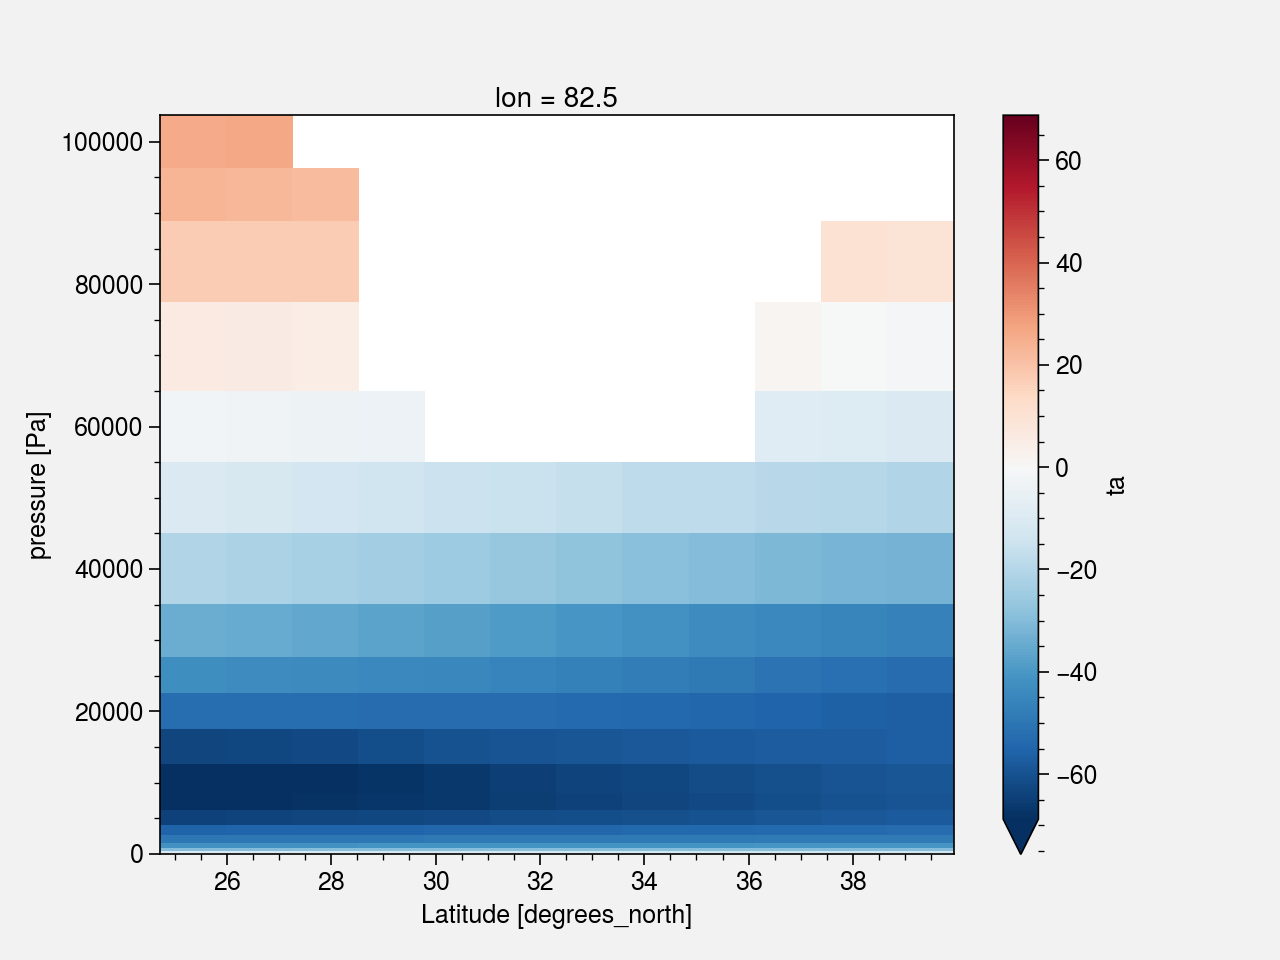

In [81]:
ta_clim.plot(robust=True)

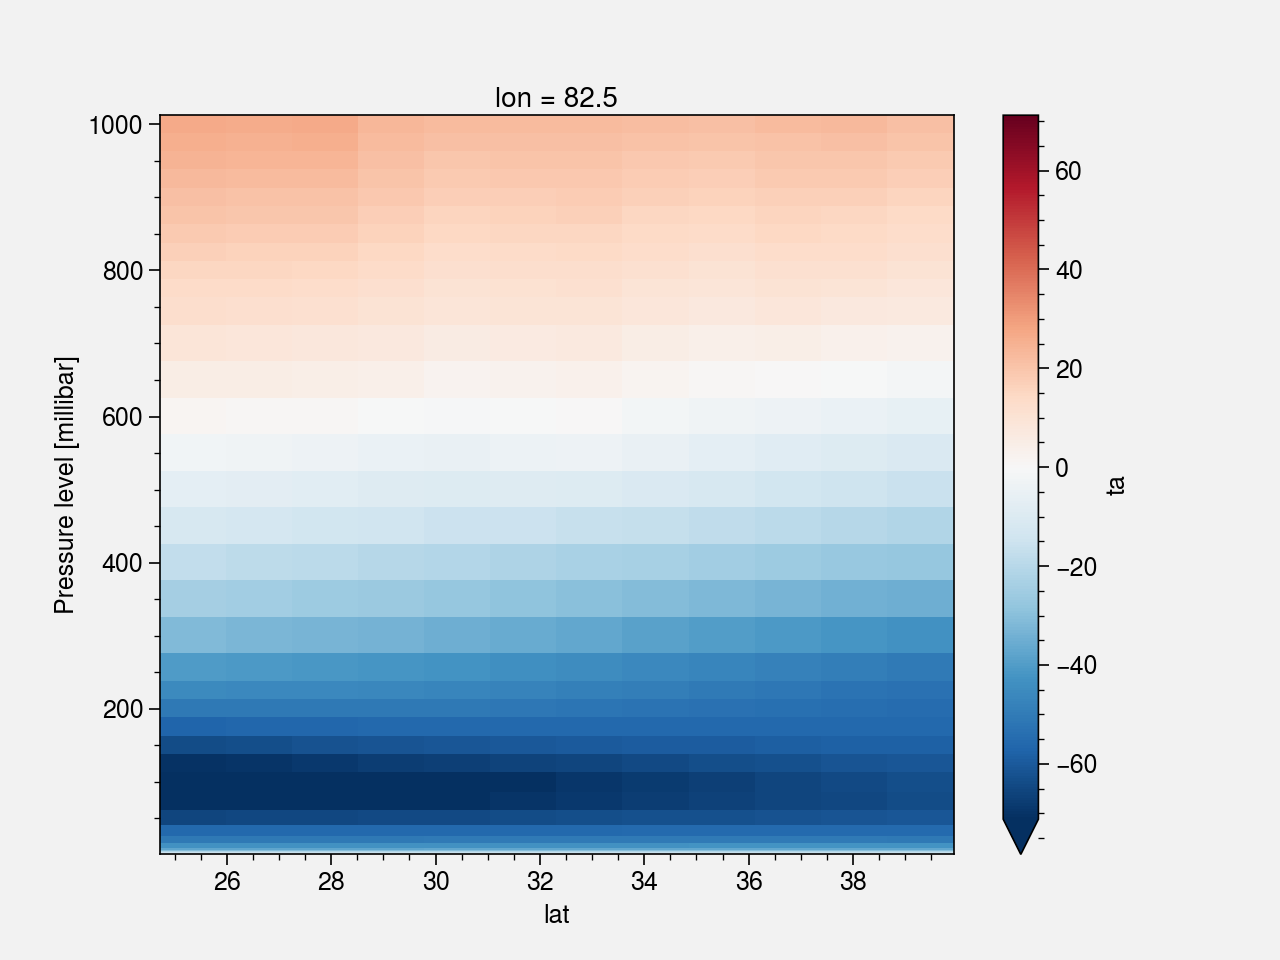

In [27]:
ta_era_regrid_clim.plot(robust=True)

In [38]:
ps_clim = ps_clim.sel(lat=slice(24.084507,40.56338), lon=82.5)

ps_era_regrid_clim = ps_era_regrid_clim.sel(lat=slice(24.084507,40.56338), lon=82.5)
ps_era_regrid_clim

<xarray.DataArray 'sp' (lat: 12)>
array([99192.67822083, 99959.43794958, 92744.67949447, 66776.06557094,
       54574.99104132, 53988.03075836, 55906.55960472, 53732.07387465,
       54795.30647383, 75523.67352787, 87805.07917856, 89316.82560936])
Coordinates:
    lon      float32 82.5
  * lat      (lat) float32 25.352112 26.619719 27.887323 ... 38.028168 39.295776

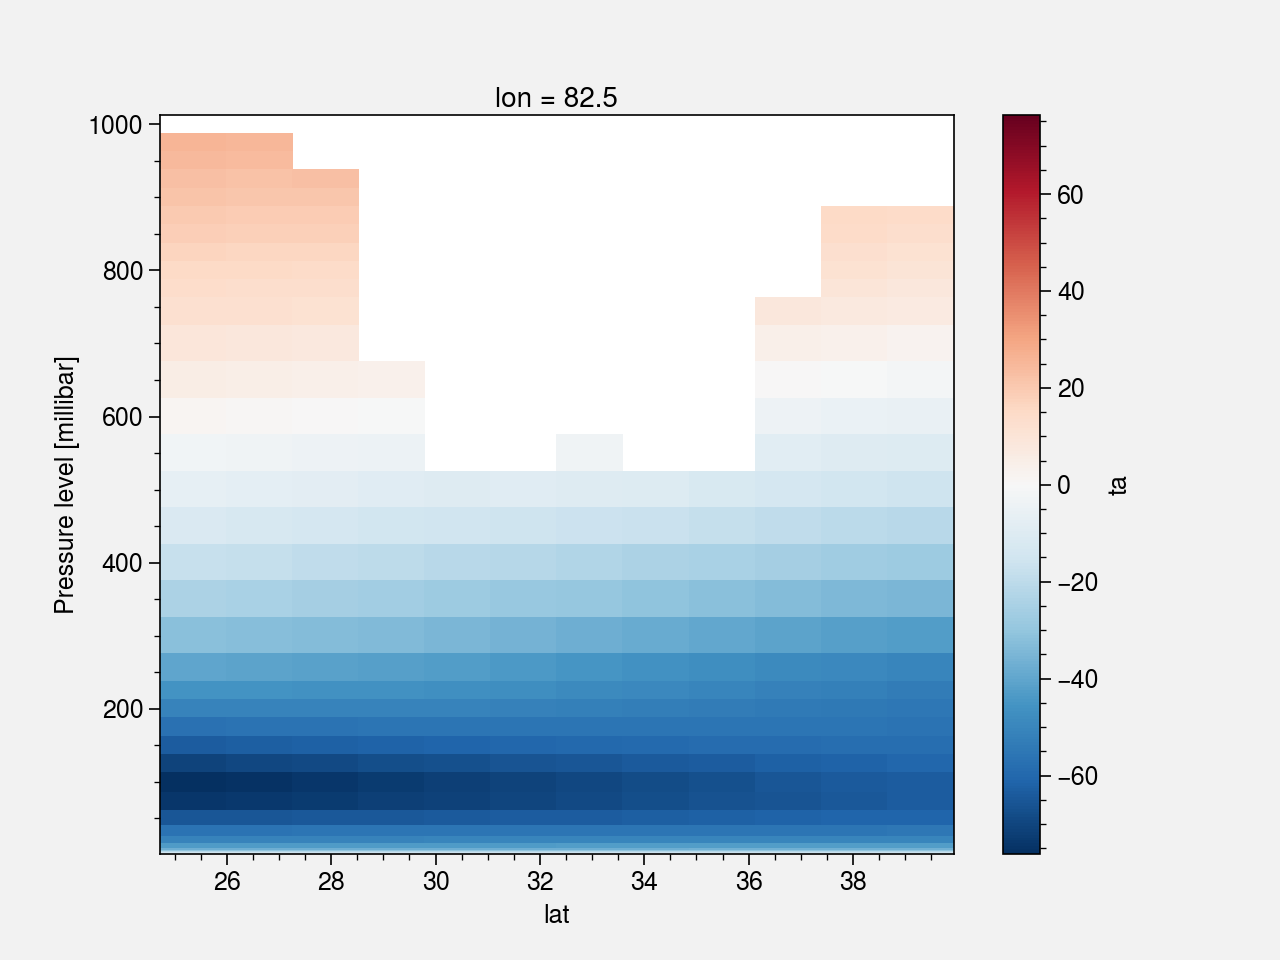

In [40]:
ta_era_regrid_clim.where(ta_era_regrid_clim.level <= ps_era_regrid_clim/100).plot()

In [41]:
ta_era_regrid_clim_masked = ta_era_regrid_clim.where(ta_era_regrid_clim.level <= ps_era_regrid_clim/100)

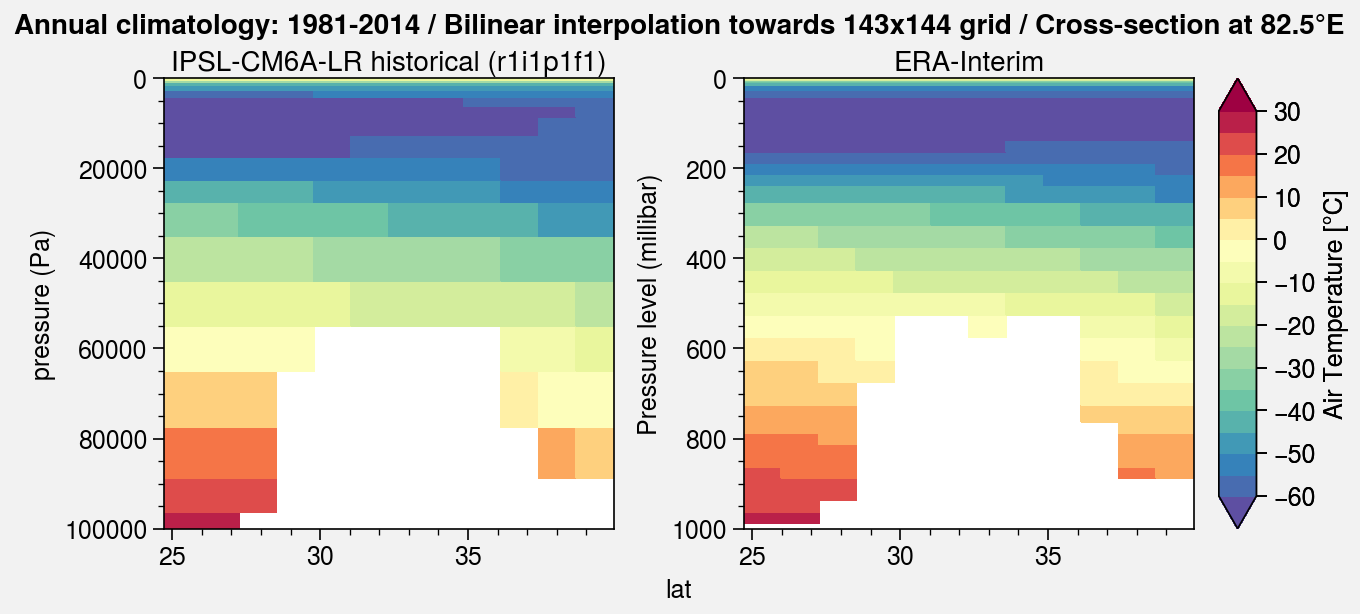

In [42]:
#Check colorbars 
levels = plot.arange(-60,30,5)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=2, sharey=0)

# Model
m = axs[0].pcolormesh(
    ta_clim, cmap=cmap, levels=levels, norm='midpoint', 
    extend=extend,
#     colorbar='r'
)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')


# ERA-Interim
axs[1].pcolormesh(
    ta_era_regrid_clim_masked, cmap=cmap, levels=levels, norm='midpoint', 
    extend=extend,
#     colorbar='r'
)
axs[1].format(ylim=(1000,0), title='ERA-Interim')

f.colorbar(m, label='Air Temperature [°C]')

axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 82.5°E"
)

# f.save('img/ta/slice_lon80_ta.png')
# f.save('img/ta/slice_lon80_ta.pdf')

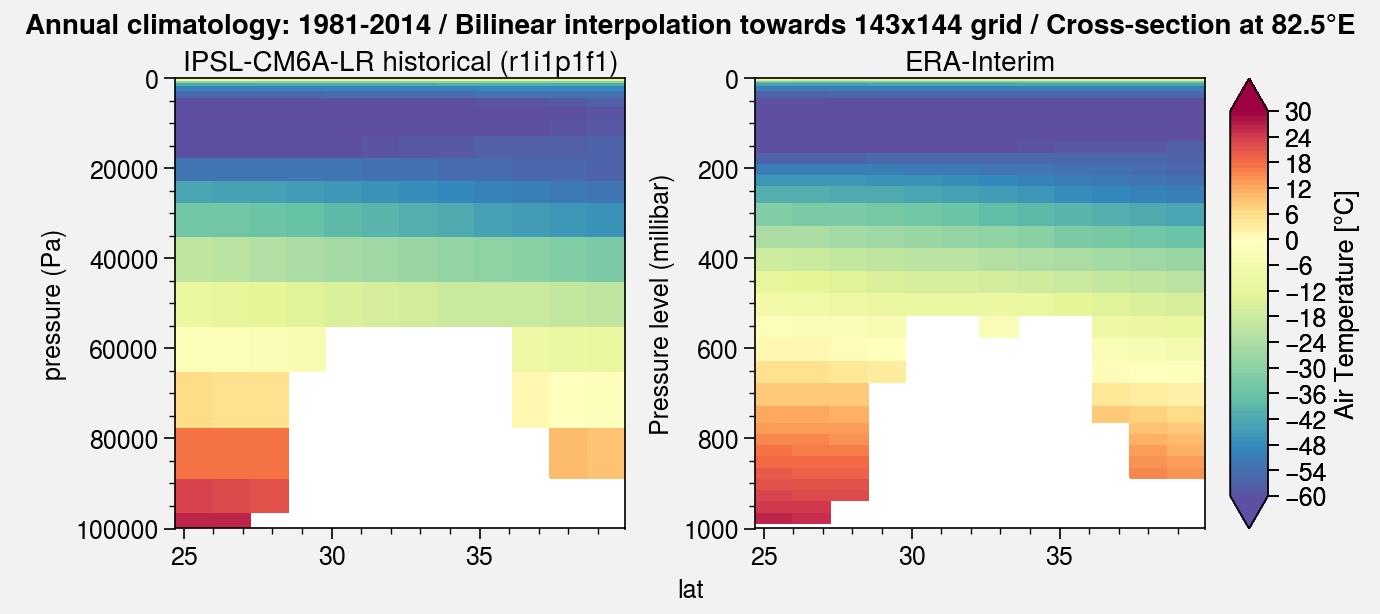

In [175]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=2, sharey=0)

# Model
m = axs[0].pcolormesh(
    ta_clim, cmap=cmap, levels=levels, norm='midpoint', 
    extend=extend,
#     colorbar='r'
)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')


# ERA-Interim
axs[1].pcolormesh(
    ta_era_regrid_clim_masked, cmap=cmap, levels=levels, norm='midpoint', 
    extend=extend,
#     colorbar='r'
)
axs[1].format(ylim=(1000,0), title='ERA-Interim')

f.colorbar(m, label='Air Temperature [°C]')

axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 82.5°E"
)

# f.save('img/ta/slice_lon_82_5_ta_pcolormesh.png')
# f.save('img/ta/slice_lon_82_5_ta_pcolormesh.pdf')

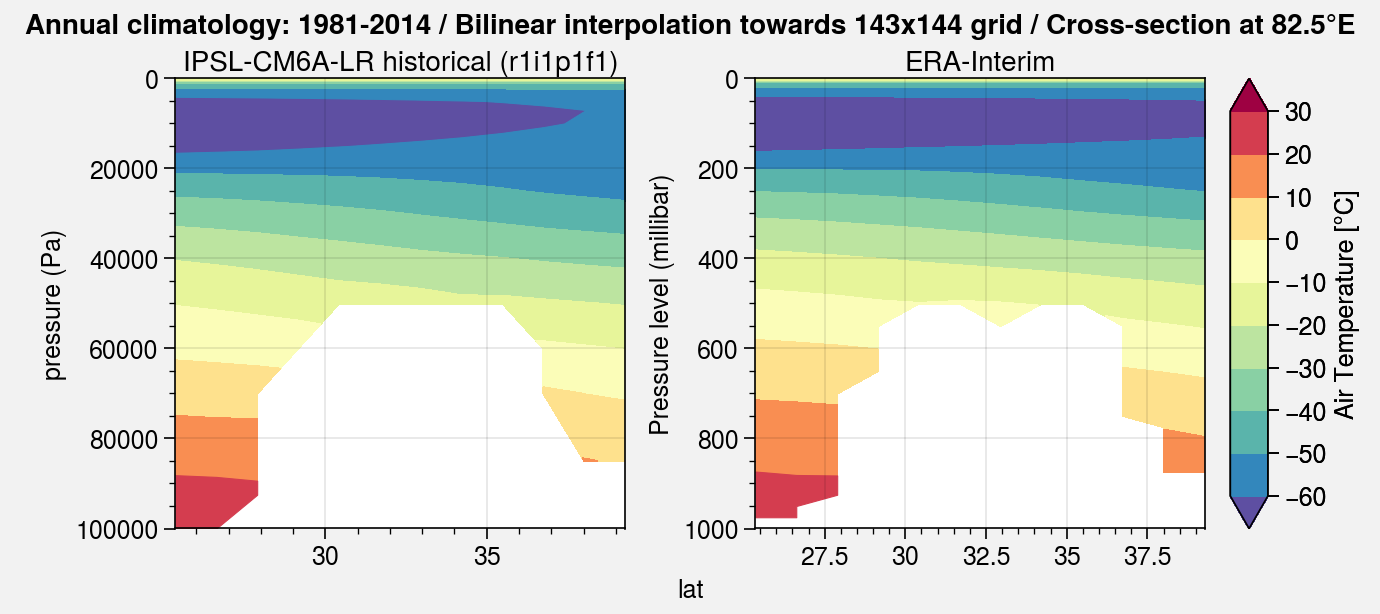

In [176]:
#Check colorbars 
levels = plot.arange(-60,30,10)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=2, sharey=0)

# Model
m = axs[0].contourf(
    ta_clim, cmap=cmap, levels=levels, norm='midpoint', 
    extend=extend,
#     colorbar='r'
)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')


# ERA-Interim
axs[1].contourf(
    ta_era_regrid_clim_masked, cmap=cmap, levels=levels, norm='midpoint', 
    extend=extend,
#     colorbar='r'
)
axs[1].format(ylim=(1000,0), title='ERA-Interim')

f.colorbar(m, label='Air Temperature [°C]')

axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 82.5°E"
)

# f.save('img/ta/slice_lon_82_5_ta_contourf.png')
# f.save('img/ta/slice_lon_82_5_ta_contourf.pdf')

# Scatter plot on one pixel
lon=82.5, lat=34.225353 (-16.4 °C)

In [148]:
tas_clim_cs = tas_clim.sel(lon=82.5, lat=slice(24.084507,40.56338))
tas_era_regrid_clim_cs = tas_era_regrid_clim.sel(lon=82.5, lat=slice(24.084507,40.56338))

In [163]:
tas_clim_cs

<xarray.DataArray 'tas' (lat: 12)>
array([ 25.051111 ,  25.288565 ,  19.94118  ,  -4.2299275, -18.600424 ,
       -14.252912 , -15.711443 , -24.02109  , -19.870823 ,   2.8503754,
         8.930199 ,   8.979068 ], dtype=float32)
Coordinates:
  * lat      (lat) float32 25.352112 26.619719 27.887323 ... 38.028168 39.295776
    lon      float32 82.5
    height   float64 2.0

In [162]:
tas_era_regrid_clim_cs

<xarray.DataArray 't2' (lat: 12)>
array([25.3927699 , 25.19009194, 20.62510441,  4.41001183, -5.22732907,
       -4.97622073, -3.51583043, -7.62469745, -8.8034385 ,  6.40700455,
       12.77321929, 12.62076676])
Coordinates:
    lon      float32 82.5
  * lat      (lat) float32 25.352112 26.619719 27.887323 ... 38.028168 39.295776

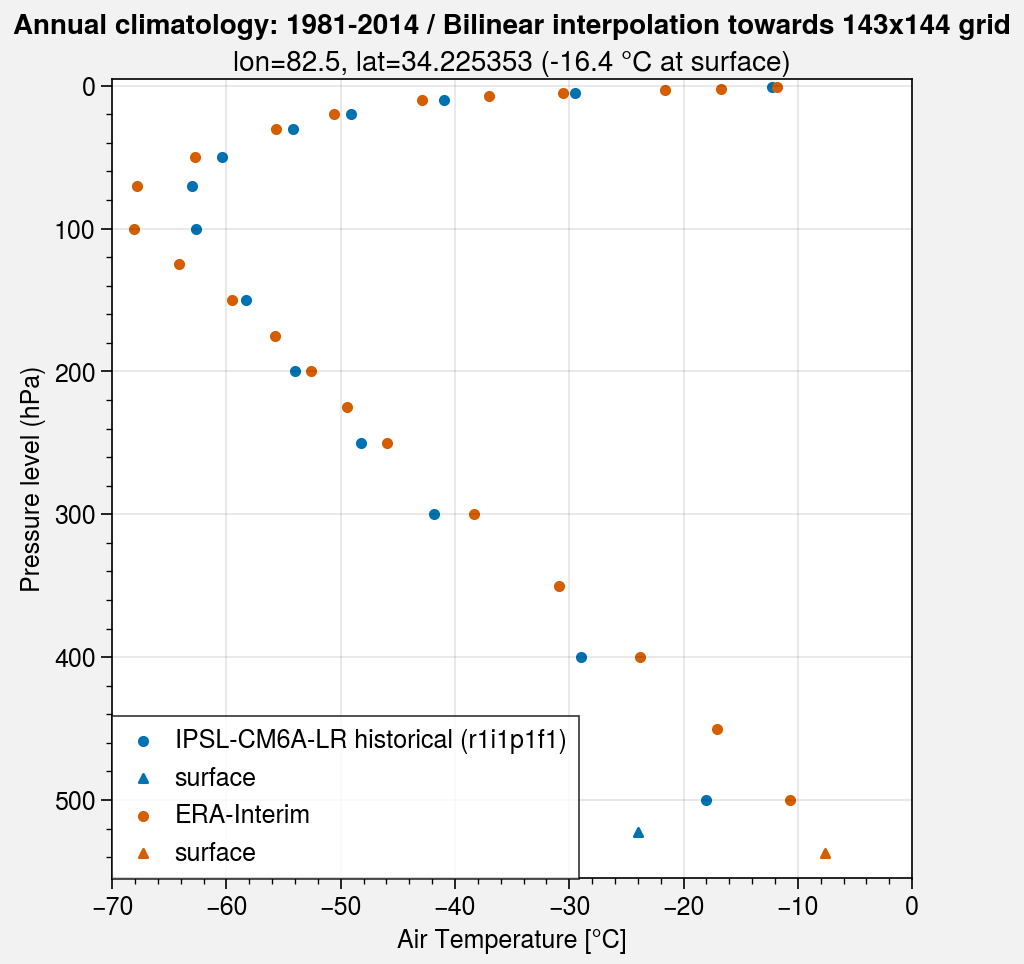

In [177]:
fig, axs = plot.subplots(nrows=1, ncols=1, axwidth=4)

h1 = axs[0].scatter(ta_clim.sel(lat=34.225353).values, ta_clim.plev.values/100, label='IPSL-CM6A-LR historical (r1i1p1f1)')
h2 = axs[0].scatter(ta_era_regrid_clim_masked.sel(lat=34.225353).values, ta_era_regrid_clim.level.values, label='ERA-Interim')

h3 = axs[0].scatter(tas_clim_cs.sel(lat=34.225353).values, ps_clim.sel(lat=34.225353).values/100, color='C0', marker='^', label='surface')
h4 = axs[0].scatter(tas_era_regrid_clim_cs.sel(lat=34.225353).values, ps_era_regrid_clim.sel(lat=34.225353).values/100, color='C1', marker='^', label='surface')


hs = [h1, h3, h2, h4]

axs[0].legend(hs, ncols=1)
axs[0].format(title='lon=82.5, lat=34.225353 (-16.4 °C at surface)')

axs.format(
    ylim=(550+5,0-5), xlim=(-70,0), 
    xlabel='Air Temperature [°C]', ylabel='Pressure level (hPa)',
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid",
)

# f.save('img/ta/vertical_profile_lon_82_5_lat_34_ta.png')
# f.save('img/ta/vertical_profile_lon_82_5_lat_34_ta.pdf')

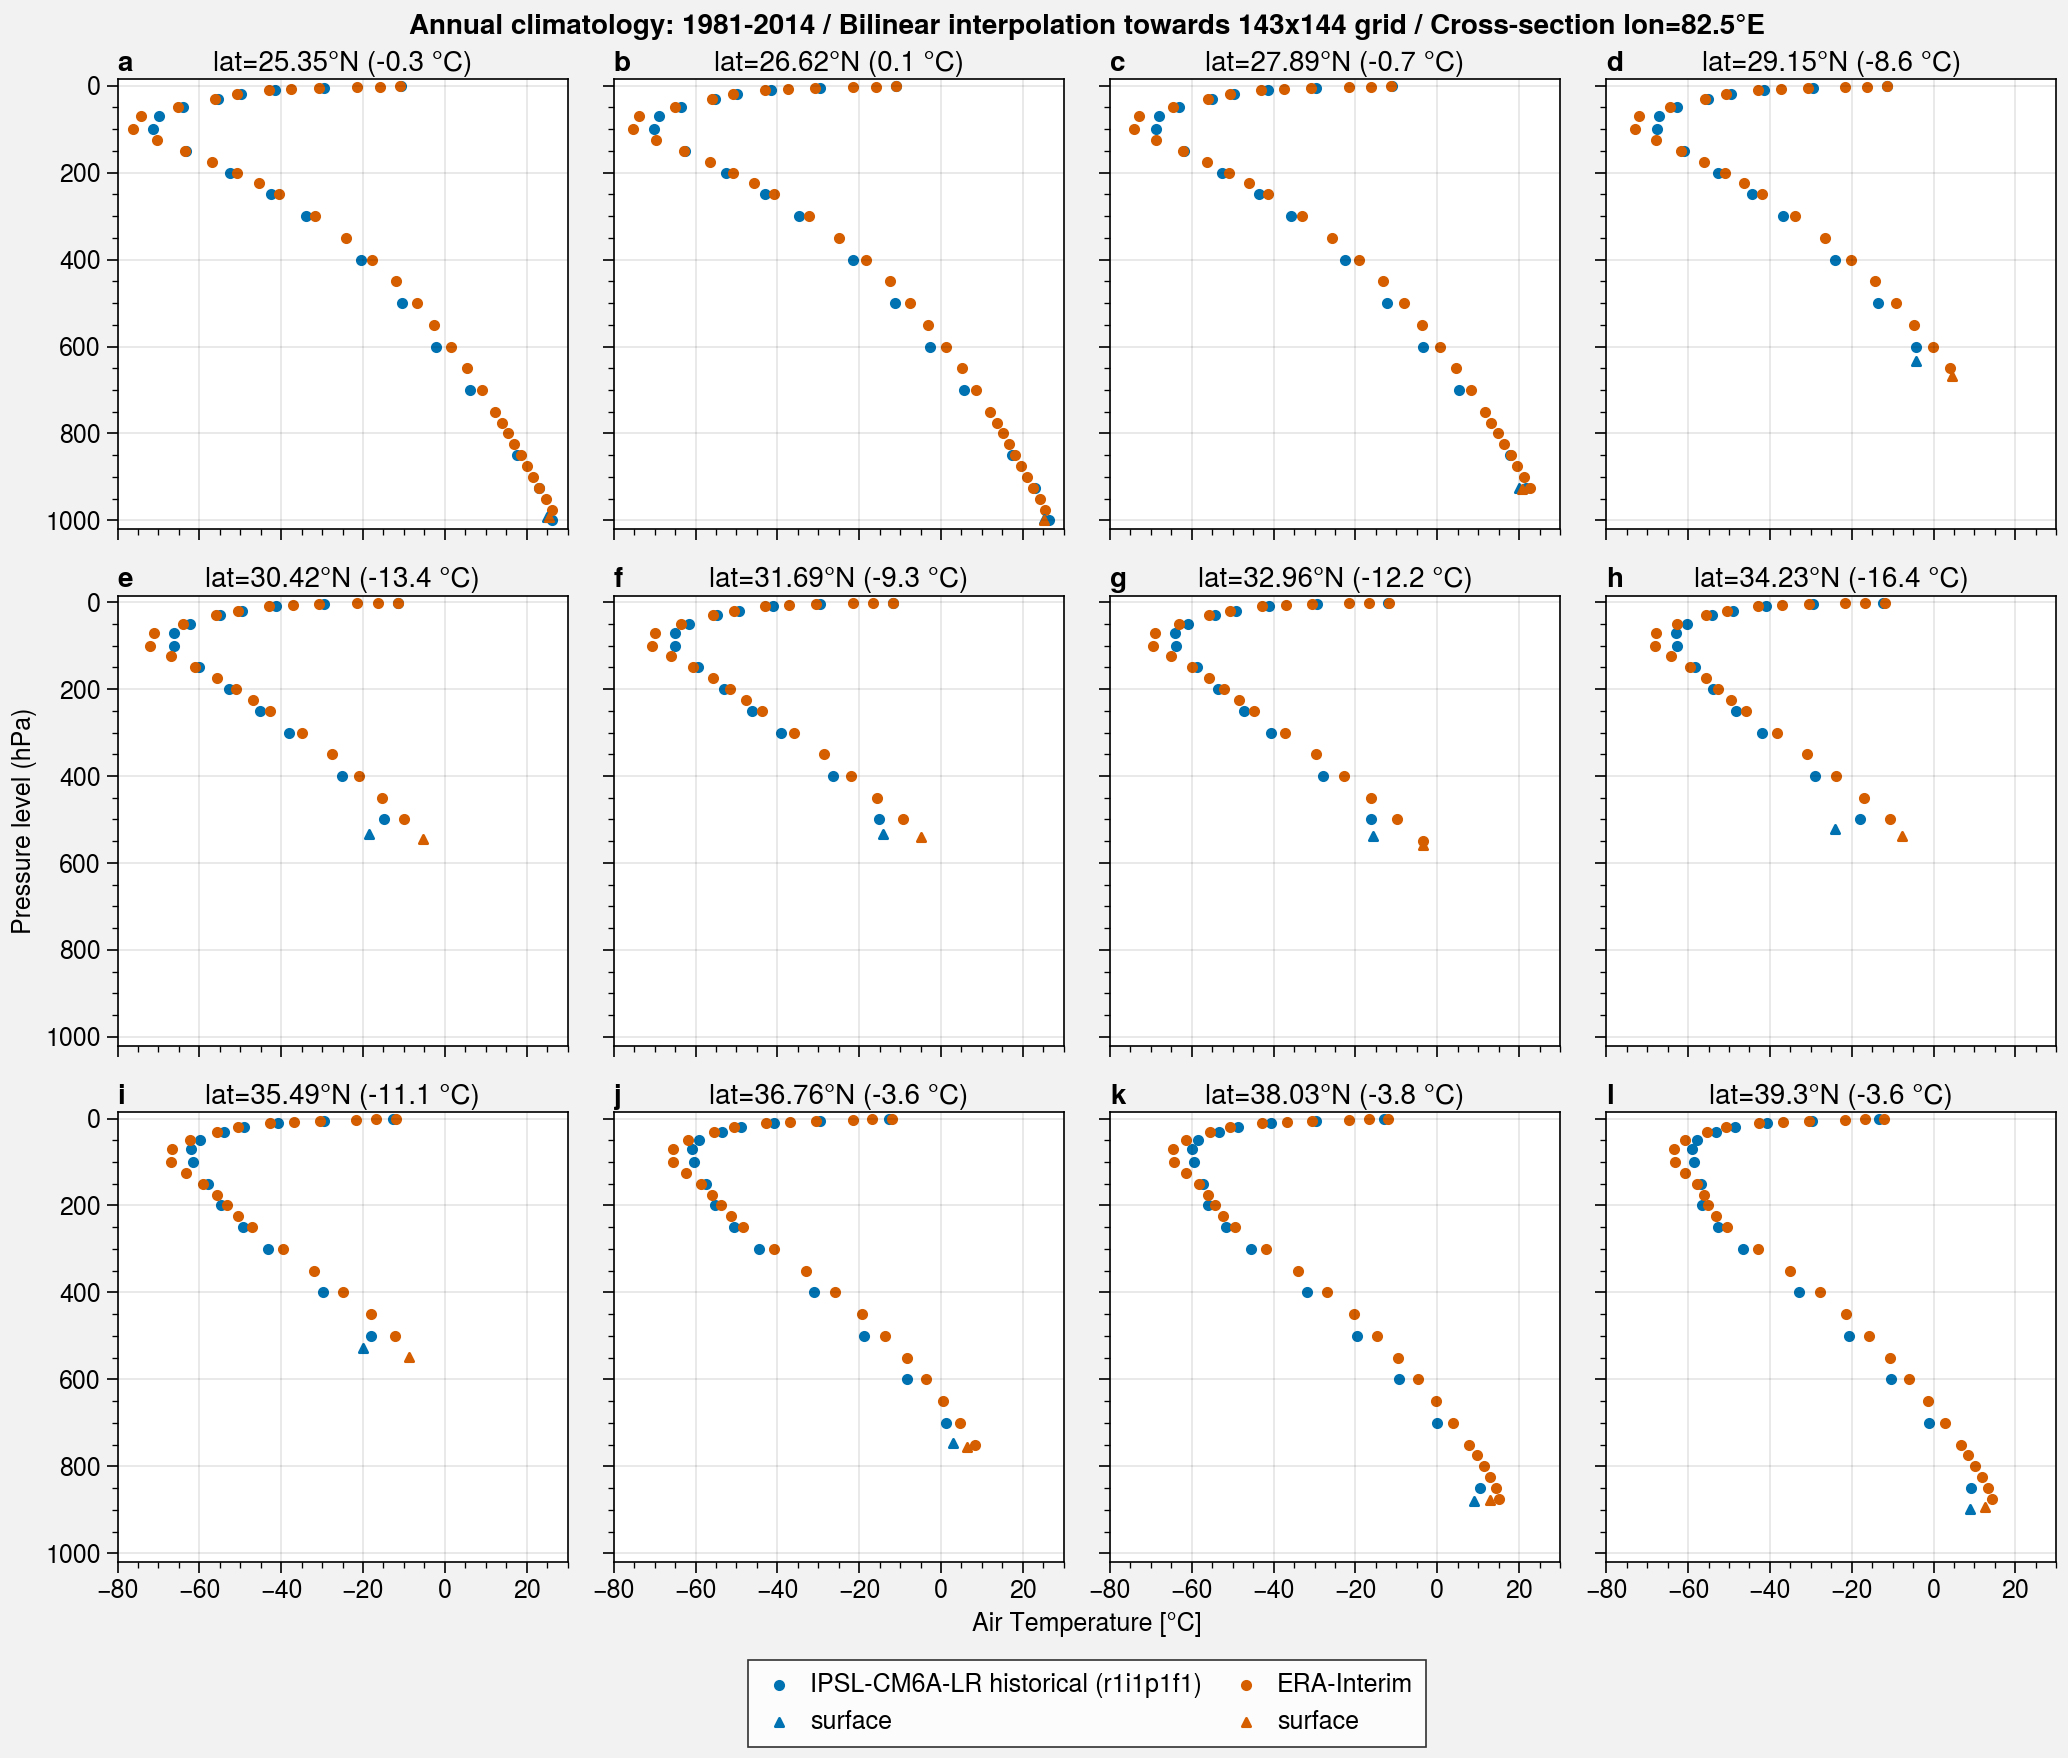

In [178]:
fig, axs = plot.subplots(nrows=3, ncols=4)

for i, ax in enumerate(axs):
    h1 = ax.scatter(ta_clim.isel(lat=i).values, ta_clim.plev.values/100, label='IPSL-CM6A-LR historical (r1i1p1f1)')
    h2 = ax.scatter(ta_era_regrid_clim_masked.isel(lat=i).values, ta_era_regrid_clim.level.values, label='ERA-Interim')
    
    h3 = ax.scatter(tas_clim_cs.isel(lat=i).values, ps_clim.isel(lat=i).values/100, color='C0', marker='^', label='surface')
    h4 = ax.scatter(tas_era_regrid_clim_cs.isel(lat=i).values, ps_era_regrid_clim.isel(lat=i).values/100, color='C1', marker='^', label='surface')
    
    ax.format(title='lat='+str(np.round(ta_clim.isel(lat=i).lat.values, 2))+'°N ('+str(np.round(tas_bias.sel(lon=82.5, lat=slice(24.084507,40.56338)).isel(lat=i).values, 1))+' °C)')
    

    hs = [h1, h2, h3, h4]

fig.legend(hs, loc='b', ncols=2)


axs.format(
    ylim=(1015+5,0-15), xlim=(-75-5,25+5), 
    xlabel='Air Temperature [°C]', ylabel='Pressure level (hPa)',
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section lon=82.5°E",
    abc=True
)

# f.save('img/ta/vertical_profile_lon_82_5_ta.png')
# f.save('img/ta/vertical_profile_lon_82_5_ta.pdf')

## Try to interpolate vertically

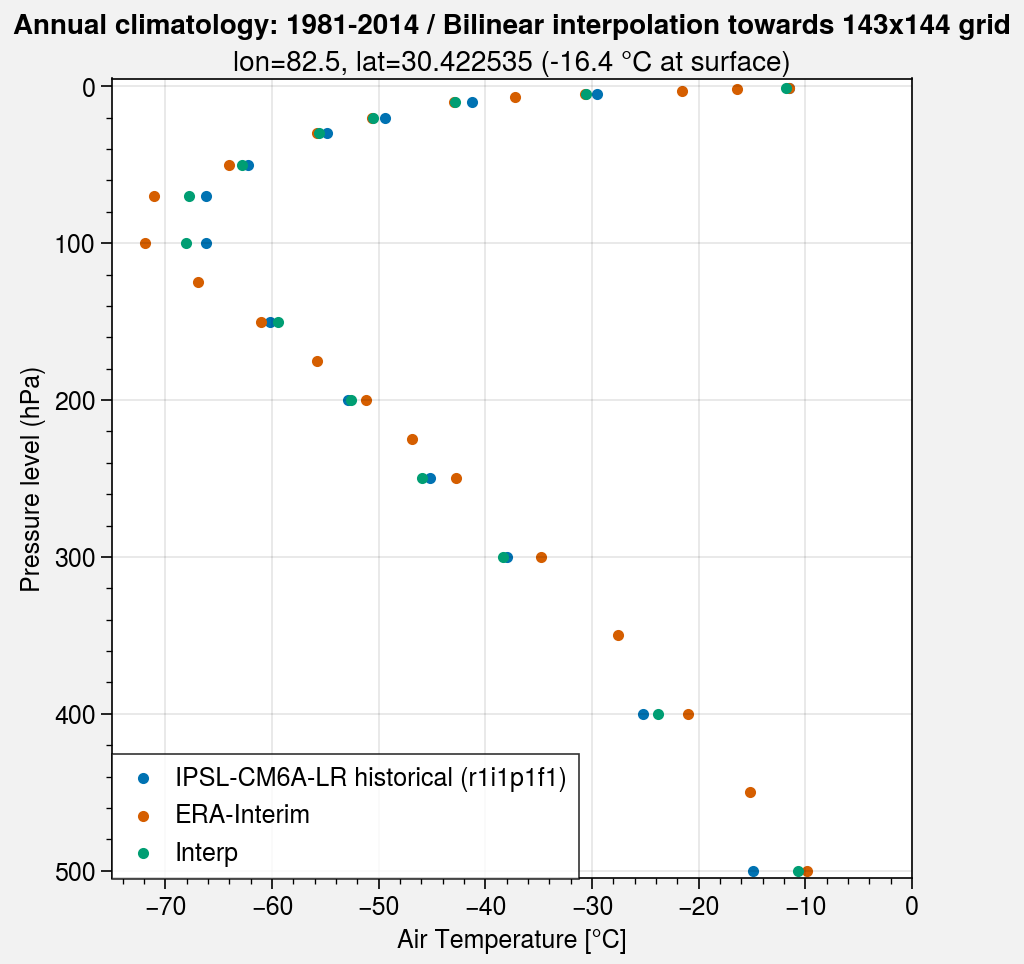

In [91]:
interp = ta_era_regrid_clim_masked.sel(lat=34.225353).dropna('level').interp(
    level=(ta_clim.plev.values/100), 
    method='quadratic'
)


fig, axs = plot.subplots(nrows=1, ncols=1, axwidth=4)

h1 = axs[0].scatter(ta_clim.sel(lat=30.422535).values, ta_clim.plev.values/100, label='IPSL-CM6A-LR historical (r1i1p1f1)')
h2 = axs[0].scatter(ta_era_regrid_clim_masked.sel(lat=30.422535).values, ta_era_regrid_clim.level.values, label='ERA-Interim')
h3 = axs[0].scatter(interp.values, interp.level.values, label='Interp', zorder=10)


hs = [h1, h2, h3]

axs[0].legend(hs, ncols=1)
axs[0].format(title='lon=82.5, lat=30.422535 (-16.4 °C at surface)')

axs.format(
    ylim=(500+5,0-5), xlim=(-75,0), 
    xlabel='Air Temperature [°C]', ylabel='Pressure level (hPa)',
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid",
)
